# Satellite Derived Bathymetry
## Preface
This is a note of how to generate a depth prediction using satellite imagery and depth sample data, also known as empirical approach Satellite Derived Bathymetry. The tools we are going to use are python and its packages. Those are:
1. [Numpy](https://numpy.org/)
2. [Scipy](https://www.scipy.org/)
3. [Pandas](https://pandas.pydata.org/)
5. [Xarray](https://xarray.dev/)
6. [Rioxarray](https://corteva.github.io/rioxarray)
7. [Geopandas](https://geopandas.readthedocs.io/)
8. [Scikit Learn](https://scikit-learn.org)
9. [Matplotlib](https://matplotlib.org/)

Please make sure to install python and the packages mentioned above. 

## Setup and Preparation
### Python and packages installation
There are many ways to install them, but I prefer using [Miniconda](https://docs.anaconda.com/miniconda/) because of its little installation size. You could refer to https://docs.anaconda.com/miniconda/install/ on how to install miniconda. After conda was installed, open anaconda prompt and create new environment using conda create below.
```bash
    # Replace <ENV_NAME> with a name for your environment
    conda create --name <ENV_NAME>
```
Then activate your new environment and install python 3.12 and the packages. But, to ensure that the packages installed are the latest version, install them from conda forge. To ensure the packages are installed from conda forge, add conda forge as priority channel.

```bash
    conda config --add channels conda-forge
```
Then activate your new environment and install python 3.12 and the packages by typing prompts below.
```bash
    conda activate <ENV_NAME>
    conda install python=3.12 numpy scipy pandas xarray rioxarray geopandas scikit-learn matplotlib
```

In order to run this notebook, you need Jupyter Lab or Jupyter Notebook. In this case, I use Jupyter Lab and to install it in conda, type prompts below.
```bash
    conda install jupyterlab
```

Now that the software preparation is complete, you could open this notebook using browser or using VS Code or another tools of your choise.


### Import
In order to execute commands from python libraries we need to import them first.

In [1]:
# Machine Learning tools from Scikit-learn
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from joblib import parallel_backend

# Used for median filter
from scipy import ndimage

# For manipulating array and dataframes
import pandas as pd
import numpy as np

# For reading geotiff and shapefile
import geopandas as gpd
import xarray as xr
import rioxarray as rxr

# For plotting
import matplotlib.pyplot as plt

# Pretty print for print neat dictionary contents
import pprint


### Dataset Information
Prepare your satellite image data and depth sample in a directory and another directory (or not) for the output data. Insert the necessary data information for processing purposes. There are six data identification that is important to the processing. Those are image filename, depth sample filename, depth header name, depth data direction whether it is positive up or down, and header name to differentiate between train and test data and its group name (if any). Type in those values into a suitable key in the dictionary. 

If you have another dataset you want to test, create another dictionary with the same structure and you can easily change between those datasets. It is for this reason that I create a function to administer file location names for input and output and another file tied identification and return it to a dictionary which contain all the necessary information.

In [2]:
# Input and output directory
dir_in = 'input/'
dir_out = 'output/'

## File information dictionary
# Pulau Karang Bongkok & Pulau Semak Daun
file_1 = {
    'img': 'image.tif',
    'sample': 'depth_sample.shp',
    'depth_header': 'Z_Koreksi',
    'depth_direction': 'down', # positive down
    'train_header': 'note',
    'train_group': 'train'
}

# Kalimantan Selatan (Pulau Laut)
file_2 = {
    'img': 'kalsel_mosaic_band_stack_raster_crop_2.tif',
    'sample': 'Kalsel_Merge_Pasut.shp',
    'depth_header': 'MSL',
    'depth_direction': 'up', # positive up
    'train_header': 'Note',
    'train_group': 'train'
}

# Morotai
file_3 = {
    'img': 'sentinel_morotai_4_bands.tif',
    'sample': 'sbes_morotai_sdb.shp',
    'depth_header': 'MSL', # belum dilihat
    'depth_direction': 'down', # positive up
    'train_header': 'Note',
    'train_group': 'train'
}

def input_metadata(location_dict:dict, input_dir:str, output_dir:str):
    """
    Function to insert all necessary data input metadata based on dictionary structure above.
    This returns to metadata dictionary that will be used in the main script.
    """

    image_location = input_dir + location_dict['img']
    sample_location = input_dir + location_dict['sample']
    new_image_location = output_dir + 'DEM_' + location_dict['img']
    depth_header = location_dict['depth_header']
    train_header = location_dict['train_header']
    train_group = location_dict['train_group']
    depth_direction = location_dict['depth_direction']

    metadata_dict = {
        'image_location': image_location,
        'sample_location': sample_location,
        'new_image_location': new_image_location,
        'depth_header': depth_header,
        'depth_direction': depth_direction,
        'train_header': train_header,
        'train_group': train_group
    }

    return metadata_dict

# Insert metadata dictionary here
input_dict = input_metadata(file_1, dir_in, dir_out) # Change dict name to change input dataset
pprint.pp(input_dict)

{'image_location': 'input/image.tif',
 'sample_location': 'input/depth_sample.shp',
 'new_image_location': 'output/DEM_image.tif',
 'depth_header': 'Z_Koreksi',
 'depth_direction': 'down',
 'train_header': 'note',
 'train_group': 'train'}


## Processing
### Read Data
Read image and depth sample data using [Rasterio](https://rasterio.readthedocs.io/) and [Geopandas](https://geopandas.readthedocs.io/) and insert them into variables. Type in file location by calling a dictionary key from `input_dict` variable.

In [3]:
# Read raster image using rioxarray
img = rxr.open_rasterio(input_dict['image_location'], masked=True)
img

<xarray.DataArray (band: 4, y: 192, x: 344)> Size: 1MB
[264192 values with dtype=float32]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 3kB 6.718e+05 6.718e+05 ... 6.752e+05 6.752e+05
  * y            (y) float64 2kB 9.372e+06 9.372e+06 ... 9.37e+06 9.37e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   0.0001
    add_offset:     0.0

In [4]:
# Read depth sample in ESRI Shapefile using geopandas
sample = gpd.read_file(input_dict['sample_location'])
print(sample.crs)

# Show sample in a table
sample

EPSG:32748


,X,Y,Z_Koreksi,note,geometry
0,674380.385,9366136.610,18.189742,train,POINT Z (674380.385 9366136.61 18.19)
1,674381.454,9366136.741,18.499742,train,POINT Z (674381.454 9366136.741 18.5)
2,674379.467,9366136.949,16.609742,train,POINT Z (674379.467 9366136.949 16.61)
3,674382.322,9366137.317,17.929742,train,POINT Z (674382.322 9366137.317 17.93)
4,674378.929,9366137.442,16.189742,train,POINT Z (674378.929 9366137.442 16.19)
...,...,...,...,...,...
10080,673371.323,9371449.837,1.806161,train,POINT Z (673371.323 9371449.837 1.806)
10081,673368.173,9371449.948,1.606161,train,POINT Z (673368.173 9371449.948 1.606)
10082,673370.582,9371450.079,1.766161,train,POINT Z (673370.582 9371450.079 1.766)
10083,673368.959,9371450.110,1.666161,train,POINT Z (673368.959 9371450.11 1.666)


### Preprocess input data
The image input is a multi layer/band array of width x height shape, which is a 3D shape. However, we need to change its shape into a 2D array by making every layer into a 1D array and concatenate it in columns for every layer. If we have a 3 layer image with 200 x 300 shape, this means that we are going to change it to an array with 60000 rows and 3 columns. This array reshaping is to accomodate depth prediction using [Scikit Learn](https://scikit-learn.org) because every layer which now becomes columns represent features thas correspond to a certain depth data.

Now that we have reshape the image array, we could remove missing data (could be NaN, Inf, or -Inf) and replace it with a unique number to avoid any error in the next process. Finally, we create a dataframe using the final array as input.

Using Xarray

Using Numpy and then insert array into a dataframe

In [5]:
# Check image size
nbands = len(img.band)
ndata = img.values[0].size

# Create empty array based on image size
bands_array = np.empty((nbands, ndata))

# Ravel arrays from each image bands
for i in range(nbands):
    bands_array[i, :] = np.ravel(img.values[i])

# Transpose the array
bands_array = bands_array.T

# Change inf and -inf values to nan (if any)
bands_array[bands_array == np.inf] = np.nan
bands_array[bands_array == -np.inf] = np.nan

# Replace nan values with -999.0
bands_array[np.isnan(bands_array)] = -999.0

# Create dataframe from bands array
bands_df = pd.DataFrame(bands_array, columns=[f'band_{i}' for i in img.band.values])
bands_df

,band_1,band_2,band_3,band_4
0,626.0,385.0,265.0,183.0
1,617.0,383.0,261.0,187.0
2,636.0,383.0,249.0,192.0
3,623.0,378.0,261.0,194.0
4,651.0,393.0,266.0,187.0
...,...,...,...,...
66043,608.0,354.0,242.0,180.0
66044,600.0,345.0,236.0,181.0
66045,595.0,354.0,246.0,178.0
66046,609.0,357.0,247.0,176.0


Check if both image and depth sample have the same Coordinate Reference System (CRS). If both have different CRS, reproject depth sample CRS to match image CRS.

In [6]:
# Retrieve CRS information from image and sample and change it to uppercase
img_crs = str(img.rio.crs).upper()
sample_crs = str(sample.crs).upper()

# Check if CRS is the same and reproject sample if not
if img_crs != sample_crs:
    sample_edit = sample.to_crs(crs=img_crs)
else:
    sample_edit = sample.copy()

# Show reprojected sample CRS
print(sample_edit.crs)

# Show reprojected sample table
sample_edit

EPSG:32748


,X,Y,Z_Koreksi,note,geometry
0,674380.385,9366136.610,18.189742,train,POINT Z (674380.385 9366136.61 18.19)
1,674381.454,9366136.741,18.499742,train,POINT Z (674381.454 9366136.741 18.5)
2,674379.467,9366136.949,16.609742,train,POINT Z (674379.467 9366136.949 16.61)
3,674382.322,9366137.317,17.929742,train,POINT Z (674382.322 9366137.317 17.93)
4,674378.929,9366137.442,16.189742,train,POINT Z (674378.929 9366137.442 16.19)
...,...,...,...,...,...
10080,673371.323,9371449.837,1.806161,train,POINT Z (673371.323 9371449.837 1.806)
10081,673368.173,9371449.948,1.606161,train,POINT Z (673368.173 9371449.948 1.606)
10082,673370.582,9371450.079,1.766161,train,POINT Z (673370.582 9371450.079 1.766)
10083,673368.959,9371450.110,1.666161,train,POINT Z (673368.959 9371450.11 1.666)


Plot image file and reprojected sample in the same graph to see both data in 1 frame

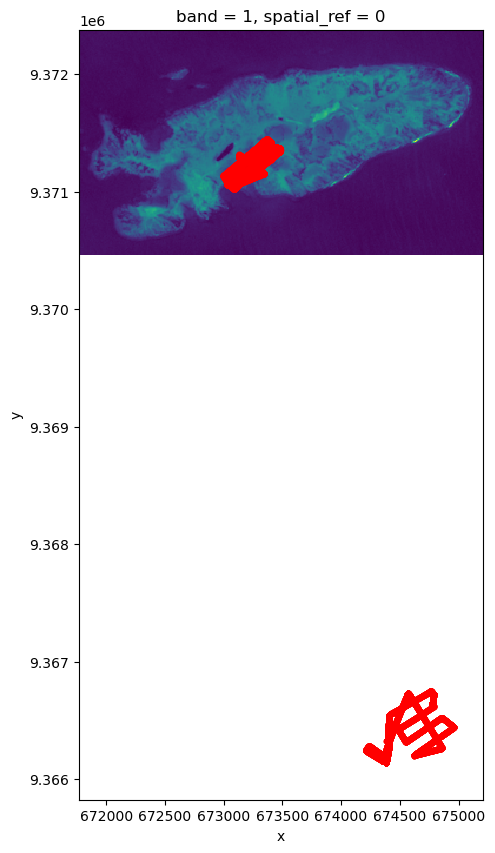

In [7]:
# Plot img dataarray band 1, 2, and 3 in one line code
fig, ax = plt.subplots(figsize=(10, 10))
img.sel(band=3).plot
img.sel(band=2).plot
img.sel(band=1).plot.imshow(add_colorbar=False)
sample_edit.plot(ax=ax, color='red', markersize=10)
plt.show()


Depth data sample might be located outside of the image boundary. This certainly could become a problem and generate error. To avoid this, filter/remove out of image boundary sample data.

In [8]:
# Insert xarray image boundary coordinates to variables
left, bottom, right, top = img.rio.bounds()
print(left, bottom, right, top)

# Exclude out of boundary points in sample_edit then reset index count to avoid error in train test split
sample_edit = sample_edit.cx[left:right, bottom:top].reset_index(drop=True)
sample_edit

671770.0 9370460.0 675210.0 9372380.0


,X,Y,Z_Koreksi,note,geometry
0,673089.824,9371020.537,10.644119,test,POINT Z (673089.824 9371020.537 10.644)
1,673090.677,9371020.627,10.654119,test,POINT Z (673090.677 9371020.627 10.654)
2,673088.900,9371020.741,10.684119,test,POINT Z (673088.9 9371020.741 10.684)
3,673091.478,9371020.835,10.314119,test,POINT Z (673091.478 9371020.835 10.314)
4,673092.281,9371021.078,8.904119,test,POINT Z (673092.281 9371021.078 8.904)
...,...,...,...,...,...
4629,673371.323,9371449.837,1.806161,train,POINT Z (673371.323 9371449.837 1.806)
4630,673368.173,9371449.948,1.606161,train,POINT Z (673368.173 9371449.948 1.606)
4631,673370.582,9371450.079,1.766161,train,POINT Z (673370.582 9371450.079 1.766)
4632,673368.959,9371450.110,1.666161,train,POINT Z (673368.959 9371450.11 1.666)


Plotting image file and sample data after excluding out of boundary points

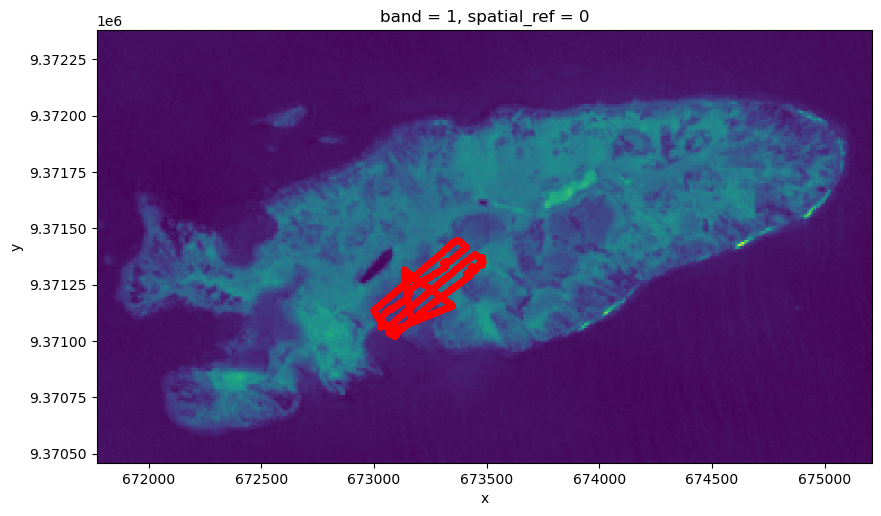

In [9]:
# Plot img dataarray band 1, 2, and 3 in one line code
fig, ax = plt.subplots(figsize=(10, 10))
img.sel(band=3).plot
img.sel(band=2).plot
img.sel(band=1).plot.imshow(add_colorbar=False)
sample_edit.plot(ax=ax, color='red', markersize=10)
plt.show()

Every sample data has its own information about its header name containing depth data and depth data direction. Depth data header will be used to call the depth data. Depth data direction is either positive up or positive down. This information is vital to how we process the data. In this notebook, we will process depth data in the positive up manner. To simplify the upcoming process of calling depth data, it is recommended to insert this value to a variable instead of calling the dictionary name and its key.

Satellite Derived Bathymetry only effective on clear shallow water. It is recommended to truncate any depth data outside a certain window. In this notebook, the depth limit window is from 1 to -10 from 0 vertical reference of input data.

In [10]:
# Insert column name into variable
depth_col = input_dict['depth_header']

# Depth data direction
# Create dictionary for depth data direction
depth_direction_dict = {
    'up': False,
    'down': True
}
depth_direction_input = depth_direction_dict[input_dict['depth_direction']]

# Set depth limit in positive up direction
depth_limit_a = 1.0 # Depth upper limit
depth_limit_b = -10.0 # Depth bottom limit

# Change depth data direction to positive up
if depth_direction_input:
    sample_edit[depth_col] *=-1

# Filter depth data based on depth limit in positive up direction
sample_edit = sample_edit[(sample_edit[depth_col] <= depth_limit_a) & (sample_edit[depth_col] >= depth_limit_b)].reset_index(drop=True)
sample_edit

,X,Y,Z_Koreksi,note,geometry
0,673092.281,9371021.078,-8.904119,test,POINT Z (673092.281 9371021.078 8.904)
1,673093.279,9371021.260,-9.914119,test,POINT Z (673093.279 9371021.26 9.914)
2,673093.042,9371021.267,-9.914119,test,POINT Z (673093.042 9371021.267 9.914)
3,673093.407,9371021.313,-9.824119,test,POINT Z (673093.407 9371021.313 9.824)
4,673093.397,9371021.821,-9.614119,test,POINT Z (673093.397 9371021.821 9.614)
...,...,...,...,...,...
4549,673371.323,9371449.837,-1.806161,train,POINT Z (673371.323 9371449.837 1.806)
4550,673368.173,9371449.948,-1.606161,train,POINT Z (673368.173 9371449.948 1.606)
4551,673370.582,9371450.079,-1.766161,train,POINT Z (673370.582 9371450.079 1.766)
4552,673368.959,9371450.110,-1.666161,train,POINT Z (673368.959 9371450.11 1.666)


### Create function to accomodate different processing workflow
Predicting depth using [Scikit Learn](https://scikit-learn.org) require separating features and label. Features are characteristics or attributes of the data while label is the value we want to predict using available features information. The final objective of this process is to separate features from label. However, to complete this, we need to do some preparation.

Create the function and return as a dataframe of features and label data and dataframe before feature label split.
What the function do are point sampling of every depth data and its coressponding image value, array reshape, change array to dataframe, append xy coordinates and depth data (z) to the dataframe, and drop missing values (could be NaN, Inf, or -Inf).

The purpose of gathering some process into this function is to accomodate different processing workflow of splitting training and testing data in the next processing stage. By creating this function, if we want to change how to do the train test split, we do not have to write the process again.

In [11]:
def preprocess(image, sample, depth_col: str):
    """
    Preprocess image and sample data to be used in machine learning model.
    Start from sampling image based on sample location,
    extract image values based on rows and columns location,
    create dataframe from sample bands, append xy, and depth data to the dataframe,
    delete rows with inf, -inf, and nan values,
    take all data as features except z data, and return features, label, and sample bands dataframe.
    Return to features, label, and sample bands dataframe.

    ### Args:
        image: image data that read using rioxarray
        sample: depth sample file that read using geopandas
        depth_col: a header name containing depth data from sample

    ### Returns:
        A tuple containing features, label, and both features and label in the same dataframe
    """

    # Sampling image based on sample location
    sample_bands_df = point_sampling(image=image, x=sample.geometry.x, y=sample.geometry.y)

    # Append xy, and depth data to the dataframe
    sample_bands_df['x'], sample_bands_df['y'], sample_bands_df['z'] = sample.geometry.x, sample.geometry.y, sample[depth_col]

    # Delete rows with inf, -inf, and nan values
    sample_bands_df = sample_bands_df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

    # Take all data as features except z data
    features = sample_bands_df.drop(columns=['z'])
    label = sample_bands_df['z']

    return features, label, sample_bands_df

def point_sampling(image, x, y):
    """
    Extract raster values from a dataarray based on xy coordinates.

    ### Args:
        image: image data that read using rioxarray
        x: x coordinates
        y: y coordinates

    ### Returns:
        A dataframe with the shape of number-of-data x number-of-layer.
    """

    x_in = xr.DataArray(x, dims=['location'])
    y_in = xr.DataArray(y, dims=['location'])

    point_samples = image.sel(x=x_in, y=y_in, method='nearest').values.T

    point_samples_df = pd.DataFrame(
        point_samples,
        columns=[f'band_{i}' for i in image.band.values]
    ).reset_index(drop=True)

    return point_samples_df


### Prepare features and label before Machine Learning processing
There are two ways to split train and test data from features and label. We could do it randomly by percentage using `train_test_split` function or by selecting manually beforehand and mark them by attributes.

In [12]:
# Create dictionary for train data selection
train_selection_dict = {
    'random': True,
    'attribute': False
}

# Set train data selection method
train_selection = train_selection_dict['random'] # Change this to change the method of train data selection

# Train data selection based on random by percentage
train_size = 0.75 # random by percentage
random_state = 0

# Train data selection based on attribute
train_attribute_header = input_dict['train_header']
train_attribute_group = input_dict['train_group']

# Condition for train data selection method
if train_selection:
    # Random by percentage
    features_all, z, sample_df = preprocess(img, sample_edit, depth_col)

    # Split data into train and test data randomly by percentage
    features_all_train, features_all_test, z_train, z_test = train_test_split(
        features_all,
        z,
        train_size=train_size,
        random_state=random_state
    )
else:
    # Attribute
    # Split data into train and test data based on attribute
    train = sample_edit[sample_edit[train_attribute_header] == train_attribute_group].reset_index(drop=True)
    features_all_train, z_train, sample_train_df = preprocess(img, train, depth_col)

    test = sample_edit[sample_edit[train_attribute_header] != train_attribute_group].reset_index(drop=True)
    features_all_test, z_test, sample_test_df = preprocess(img, test, depth_col)

    # Combine sample_train_df and sample_test_df
    sample_df = pd.concat([sample_train_df, sample_test_df], ignore_index=True)

# Exclude xy data from features so it won't affect the prediction
features_train = features_all_train.drop(columns=['x', 'y'])
features_test = features_all_test.drop(columns=['x', 'y'])

# Merge features and z data for train and test data into one dataframe
train_df = pd.concat([features_all_train, z_train], axis=1).reset_index(drop=True)
test_df = pd.concat([features_all_test, z_test], axis=1).reset_index(drop=True)

sample_df

,band_1,band_2,band_3,band_4,x,y,z
0,725.0,520.0,296.0,200.0,673092.281,9371021.078,-8.904119
1,725.0,520.0,296.0,200.0,673093.279,9371021.260,-9.914119
2,725.0,520.0,296.0,200.0,673093.042,9371021.267,-9.914119
3,725.0,520.0,296.0,200.0,673093.407,9371021.313,-9.824119
4,725.0,520.0,296.0,200.0,673093.397,9371021.821,-9.614119
...,...,...,...,...,...,...,...
4549,1188.0,1213.0,635.0,189.0,673371.323,9371449.837,-1.806161
4550,1188.0,1230.0,727.0,187.0,673368.173,9371449.948,-1.606161
4551,1154.0,1141.0,578.0,173.0,673370.582,9371450.079,-1.766161
4552,1203.0,1196.0,676.0,177.0,673368.959,9371450.110,-1.666161


### Predicting depth using [Scikit Learn](https://scikit-learn.org)
There are many machine learning estimator. In this case, we are going to use Random Forest. In the previous process, we have split the data into train and test of features and label. The next thing to do is deciding on hyperparameter values. When the hyperparameters are set, we could train a model using training data and then create a prediction based on the model.

To calculate the model accuracy, we use the test data that was separated using the trained model in the prediction. The resulting data using test data (`z_validate`) then compared against `z_test` by calculating its RMSE, MAE, and R<sup>2</sup>.

In [13]:
# Create regressor using Random Forest
regressor = RandomForestRegressor(
    n_estimators=300,
    criterion='squared_error',
)

# Train the model and predict the depth of image using parallel backend
with parallel_backend('threading', n_jobs=-2):
    regressor.fit(features_train, z_train)
    z_predict = regressor.predict(bands_df)

    z_validate = regressor.predict(features_test)

# Add z_validate to test_df
test_df['z_validate'] = z_validate

Depth prediction result in `z_predict` is a 1D array with the sum of width x height data. This type of array should not be presented as a picture. The better representation of depth or elevation data is in a 2D array with depth information. Because of this, we have to reshape `z_predict` 1D array into 2D array in the shape of input image.

Filter output based on its depth limitation and change values to nan. Reshape depth prediction that is in 1D shape array into its original shape (input image). Filter result using median filter to remove salt & pepper noise.

In [14]:
# Filter z_predict based on depth limit in positive up direction and change to nan if out of limit
z_predict[(z_predict > depth_limit_a) | (z_predict < depth_limit_b)] = np.nan

# Reshape z_predict to image shape
az_predict = z_predict.reshape(img.values[0].shape)

# Median filter to remove noise
az_predict_filter = ndimage.median_filter(az_predict, size=3) # Change the size to change the filter strength

### Convert prediction result to a dataarray

Create a function that convert depth prediction data in numpy array to a dataarray.

In [15]:
def array_to_dataarray(np_array, rioxarray_da, band_name=1, attrs=False):
    """
    Create a new Dataarray from a Numpy array based on rioxarray image specification but only contain 1 band.

    ### Args:
        np_array: image data that read using rioxarray
        rioxarray_da: dataarray from rioxarray
        band_name: a name for a band
        attrs: attributes

    ### Returns:
        A dataarray with the same dimension and coordinates as input dataarray
    """

    new_da = xr.DataArray(
        np_array[np.newaxis, :, :],
        dims=rioxarray_da.dims,
        coords={'band': [band_name], 'y': rioxarray_da.coords['y'], 'x': rioxarray_da.coords['x']},
        attrs=rioxarray_da.attrs if attrs else None
    )

    new_da.rio.write_crs(rioxarray_da.rio.crs, inplace=True)

    return new_da

Convert 2 depth prediction data (before and after median filtering) in numpy array to 1 dataarray.

In [16]:
# Create a dictionary containing 2 arrays
array_dict = {
    'z_predict': az_predict,
    'z_predict_filter': az_predict_filter
}

# Create a dataarray containing prediction before and after median filtering
daz_predict = xr.concat(
    [
        array_to_dataarray(
            list(array_dict.values())[i],
            img,
            band_name=i+1
        ) for i in range(len(array_dict))
    ],
    dim='band'
)
daz_predict

<xarray.DataArray (band: 2, y: 192, x: 344)> Size: 1MB
array([[[-9.27336644, -9.27336644, -9.37197205, ..., -9.27336644,
         -9.27336644, -9.27336644],
        [-9.27336644, -9.27336644, -9.27336644, ..., -9.27336644,
         -9.34665727, -9.27336644],
        [-9.27336644, -9.37197205, -9.27336644, ..., -9.27336644,
         -9.27336644, -9.27336644],
        ...,
        [-9.3720032 , -9.3720032 , -9.3720032 , ..., -9.27336644,
         -9.27336644, -9.27336644],
        [-9.27336644, -9.36595014, -9.37002395, ..., -9.27336644,
         -9.27336644, -9.27336644],
        [-9.37002395, -9.02126633, -9.37002395, ..., -9.27336644,
         -9.27336644, -9.27336644]],

       [[-9.27336644, -9.27336644, -9.27336644, ..., -9.27336644,
         -9.27336644, -9.27336644],
        [-9.27336644, -9.27336644, -9.27336644, ..., -9.27336644,
         -9.27336644, -9.27336644],
        [-9.27336644, -9.27336644, -9.27336644, ..., -9.27336644,
         -9.27336644, -9.27336644],
        ...,
        [-9.3720032 , -9.3720032 , -9.3720032 , ..., -9.27336644,
         -9.27336644, -9.27336644],
        [-9.37002395, -9.37002395, -9.37002395, ..., -9.27336644,
         -9.27336644, -9.27336644],
        [-9.36595014, -9.37002395, -9.37002395, ..., -9.27336644,
         -9.27336644, -9.27336644]]], shape=(2, 192, 344))
Coordinates:
  * band         (band) int64 16B 1 2
  * y            (y) float64 2kB 9.372e+06 9.372e+06 ... 9.37e+06 9.37e+06
  * x            (x) float64 3kB 6.718e+05 6.718e+05 ... 6.752e+05 6.752e+05
    spatial_ref  int64 8B 0

## Post Processing
### Evaluate result
Extract prediction depth value using test data.

In [17]:
predict_sample_df = point_sampling(
    image=daz_predict,
    x=test_df.x,
    y=test_df.y
)

predict_sample_df.columns = list(array_dict.keys())
predict_sample_df

,z_predict,z_predict_filter
0,-0.749451,-0.852241
1,-0.879137,-0.892328
2,-2.735927,-2.732540
3,-1.333213,-1.289317
4,-0.623794,-0.850189
...,...,...
1134,-9.437001,-8.217735
1135,-0.927660,-0.847699
1136,-7.134492,-6.989810
1137,-1.921771,-1.921771


Calculate RMSE, MAE, and R squared using z test data against z_validate, z_predict, and z_predict after median filter

In [18]:
# Evaluate results
rmse = np.sqrt(metrics.mean_squared_error(test_df.z, test_df.z_validate))
mae = metrics.mean_absolute_error(test_df.z, test_df.z_validate)
r2 = metrics.r2_score(test_df.z, test_df.z_validate)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R\u00B2: {r2}')

RMSE: 0.26726776083249787
MAE: 0.15835555181575406
R²: 0.9790914644647625


In [19]:
# Evaluate results
rmse = np.sqrt(metrics.mean_squared_error(test_df.z, predict_sample_df.z_predict))
mae = metrics.mean_absolute_error(test_df.z, predict_sample_df.z_predict)
r2 = metrics.r2_score(test_df.z, predict_sample_df.z_predict)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R\u00B2: {r2}')

RMSE: 0.26726776083249787
MAE: 0.15835555181575403
R²: 0.9790914644647625


In [20]:
# Evaluate results
rmse = np.sqrt(metrics.mean_squared_error(test_df.z, predict_sample_df.z_predict_filter))
mae = metrics.mean_absolute_error(test_df.z, predict_sample_df.z_predict_filter)
r2 = metrics.r2_score(test_df.z, predict_sample_df.z_predict_filter)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R\u00B2: {r2}')

RMSE: 0.3476597288950279
MAE: 0.23038890851420213
R²: 0.964621514352408


In [21]:
# Depth direction output
depth_direction_output = depth_direction_dict['up'] # Change this to change the direction of the depth data output
# Change depth data direction of predicted array, train and test z, test z_validate if needed
if depth_direction_output:
    az_predict_filter *=-1
    test_df['z'] *=-1
    test_df['z_validate'] *=-1
    train_df['z'] *=-1


Draw a scatter plot

In [22]:
def scatter_plotter(x, y, plot_color='royalblue', line_color='r', title='Scatter Plot'):
    """
    Create a scatter plot of in situ depth against predicted depth and plot a y=x line

    ### Args:
        x: x coordinates
        y: y coordinates
        plot_color: point color
        line_color: line color
        title: graph title

    ### Returns:
        A tuple of figure and axes
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(x, y, marker='.', color=plot_color, facecolors='none')
    min_val, max_val = round(np.nanmin(x)), round(np.nanmax(x))
    ax.plot([min_val, max_val], [min_val, max_val], color=line_color)
    ax.set_xlabel('True Depth')
    ax.set_ylabel('Predicted Depth')
    ax.set_title(title)

    return fig, ax

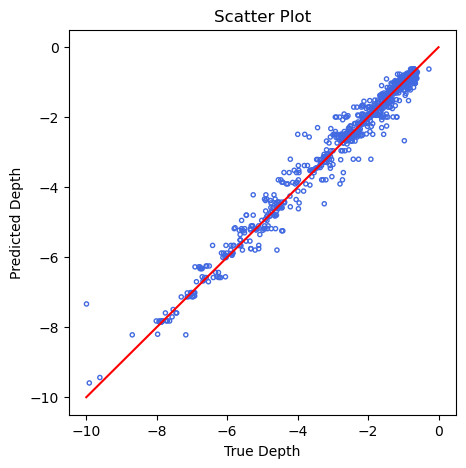

In [23]:
pfig, pax = scatter_plotter(
    x=test_df.z,
    y=predict_sample_df.z_predict
)